## TP DEEP LEARNING : Classification d'images de bateaux

##### Consigne 0 : Créer un dossier "images_g_148" dans le répertoire du TP
##### Consigne 1 : Compléter les zones "#A COMPLETER#" placées dans les cellules de code des parties III, IV, V, VI.
##### Consigne 2 : Exécuter les cellules des parties I à VI.

### I. Import des librairies

In [1]:
# Import des librairies
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras
#from keras.utils import load_img, img_to_array, array_to_img
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.layers import Input, Dense, Flatten 

from PIL import Image
%load_ext tensorboard
import datetime

import seaborn as sns

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print("Tensorflow version : ", tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4734165503238223855
]


## II. Chargement et traitement des données

### Exercice :
- Parcourez le fichier de la base de données. Que remarquez-vous ?

In [5]:
# Import des données
path = "./images"
#df = pd.read_csv('./train.csv', delimiter = ';', dtype={'image': 'object', 'category': 'int8'})
df = pd.read_csv('./train.csv', dtype={'image': 'object', 'category': 'int8'})
df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [6]:
# Analyse rapide des données :
ship = {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

ship = dict([[v,k] for k,v in ship.items()])
df['ship'] = df['category'].map(ship).astype('category')
#labels = list(df['ship'].unique())

print('Les 5 classes sont réparties telles que : \n')
print(df['ship'].value_counts(normalize=False))

Les 5 classes sont réparties telles que : 

Cargo       2120
Tankers     1217
Military    1167
Carrier      916
Cruise       832
Name: ship, dtype: int64


In [8]:
# Conversion des images couleurs en niveaux de gris
def color_to_grey(df, path_i, path_o, target_size=(img_size,img_size)):
    for file in df['image'].values:
        img = Image.open(os.path.join(path_i, file))
        imgGrey = img.convert('L')
        imgGrey.save(os.path.join(path_o, file))
    return

In [9]:
# Chargement des images en tableau
def load_data(df, path, target_size=(img_size,img_size)):
    array = []

    for file in df['image'].values:
        img = load_img(os.path.join(path, file), target_size=target_size)
        img = img_to_array(img)/255. # normalize image tensor
        array.append(img)
        
    return np.asarray(array)

In [10]:
# Traitement des données : (Prend un certain temps)

# Etape 1 - Conversion des images en niveau de gris 
path_i = path
path_o = './images_g_224'
color_to_grey(df, path_i, path_o, target_size=(img_size,img_size))

# Etape 2 - Chargement des images dans un tableau
X = load_data(df, path=path_o, target_size=(img_size,img_size))
print('Dimensions de X : ', X.shape)

#Etape 3 - Encodage des labels 
ohe = OneHotEncoder(dtype='int8', sparse=False)
y = ohe.fit_transform(df['category'].values.reshape(-1,1))
print('Dimensions de Y : ', y.shape)

Dimensions de X :  (6252, 224, 224, 3)
Dimensions de Y :  (6252, 5)


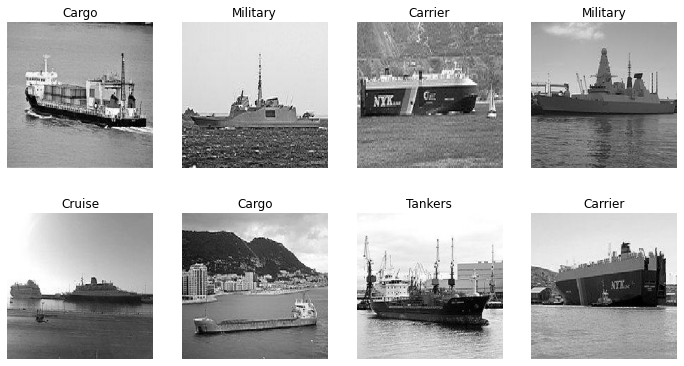

In [11]:
# Affichage des 8 premières images :
plt.figure(figsize=(12,24))

for i in range(1,9):
    plt.subplot(7,4,i)
    plt.title(f'{df["ship"].values[i]}')
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

## III. Séparation des jeux d'entrainement et de test

In [12]:
# Paramètres pour la séparation des jeux de TRAIN et de TEST
test_s = 0.1 # Ratio des tailles des jeux Train/Test          #A COMPLETER#
seed = 1234

In [13]:
# Séparation des jeux de TRAIN et de TEST
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=test_s, shuffle=True, random_state=seed)

print('Dimension X_train :', X_train.shape)
print('Dimension Y_train :', Y_train.shape)

print('Dimension X_test :', X_test.shape)
print('Dimension Y_test :', Y_test.shape)

Dimension X_train : (5626, 224, 224, 3)
Dimension Y_train : (5626, 5)
Dimension X_test : (626, 224, 224, 3)
Dimension Y_test : (626, 5)


## IV. Création de l'architecture du réseau

In [14]:
num_classes = 5 # Nombre de classes #A COMPLETER# num_classes

In [15]:
def init_model():
    model = keras.Sequential(
        [
            keras.Input(shape=(img_size,img_size,3)),       # (#A COMPLETER#, #A COMPLETER#, 3)
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), #A COMPLETER# relu
            layers.MaxPooling2D(pool_size=(2, 2)),
            
            layers.Flatten(),
            layers.Dense(64, activation="relu"),            
            layers.Dense(num_classes, activation="softmax"), #A COMPLETER# num_classes
            
        ]
    )
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## V. Entrainement du réseau et validation croisée
#### Liste des paramètres à régler pour optimiser les performances : 
        Nombre d'époques, taille de batch (max 32), nombre de couches, fonction d'activation, Dropout, Optimizer,
        Normalisation par batch, kernel_size, pool_size

In [41]:
# Paramètres d'apprentissage :
k_folds = 1 #A COMPLETER#
val_s = 0.2 #A COMPLETER#
n_epochs = 5 #A COMPLETER#
batch_size = 32 #A COMPLETER#
history_tab = []
accuracy_t_tab = np.zeros(k_folds) #k_folds découpages


# Entrainement et validation croisée : (Prend un certain temps)
for i in range(k_folds):
    seed = i
    X_train2, X_val, Y_train2, Y_val = model_selection.train_test_split(X_train, Y_train, test_size=val_s, random_state=seed)
    
    # Initialisation du réseau :
    model = init_model()
    
    # Visualisation de l'acrhitecture :
    if i == 0: 
        print('Architecture du modèle : ')
        model.summary()
        print("\nLancement de l'apprentissage :")
        
    # Apprentissage sur le jeu (X_train2, Y_train2)
    print("Découpage "+str(i)+ ' :' )
    history = model.fit(X_train2, Y_train2, 
                        validation_data=(X_val, Y_val),
                        batch_size=batch_size, 
                        epochs = n_epochs) 
    
    history_tab.append(history)
    
    # Validation sur le jeu (X_val, Y_val)
    pred = model.predict(X_val) 
    accuracy_t_tab[i] = accuracy_score(np.argmax(Y_val, axis=1), np.argmax(pred, axis=1))  
    

accuracy_t_moy = accuracy_t_tab.mean()
print('\nPrécision moyenne : ', accuracy_t_moy)

Architecture du modèle : 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                11944000  
_________________________________________________________________
dense_9 (Dense)             

## VI. Entrainement final et Test du réseau entrainé
### Entrainement sur (X_train, Y_train) et Test sur (X_test, Y_test)

In [43]:
# Initialisation du monitoring de l'entrainement :
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [19]:
# Paramètres d'apprentissage : 
n_epochs = 4 #A COMPLETER#
batch_size = 32 #A COMPLETER#

# Initialisation du réseau :
model = init_model()

# Visualisation de l'acrhitecture :
print('Architecture du modèle : ')
model.summary()
print("\nLancement de l'apprentissage :")

# Apprentissage sur le jeu (X_train, Y_train)
history_f = model.fit(X_train, Y_train, 
                    validation_split= 0.25, #A COMPLETER#
                    batch_size=batch_size, 
                    epochs = n_epochs,
                   callbacks=[tensorboard_callback]) 


Architecture du modèle : 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                11944000  
_________________________________________________________________
dense_3 (Dense)             

In [44]:
# Lancement de la visualisation des logs de monitoring (pour suivi) :
#!rm -rf logs
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11908), started 2 days, 21:56:32 ago. (Use '!kill 11908' to kill it.)

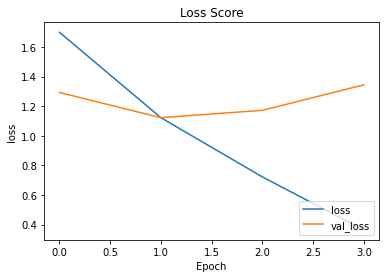

In [21]:
# Model evaluation
plt.title('Loss Score')
plt.plot(history_f.history['loss'], label='loss')
plt.plot(history_f.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

In [22]:
def test_model(model, X_test, Y_test):
     # TEST sur le jeu (X_test, Y_test)
    pred_f = model.predict(X_test) 
    accuracy_f= accuracy_score(np.argmax(Y_test, axis=1), np.argmax(pred_f, axis=1))  
    print("Précision sur jeu de TEST : "+ str(accuracy_f*100)+ '%')
    
    # Matrice de confusion sur données de test :
    cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(pred_f, axis=1))

    ship_bis = dict([[v,k] for k,v in ship.items()]) # Pour accéder facilement aux noms des bateaux
    labels = ship_bis.keys()

    plt.figure(figsize=(9,9))
    sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return

Précision sur jeu de TEST : 58.46645367412141%


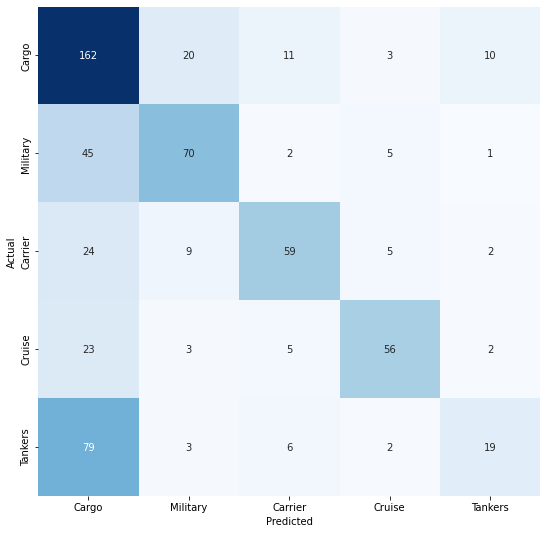

In [23]:
# Evaluation du modèle sur jeu de test :
test_model(model, X_test, Y_test) #A COMPLETER#

### Exercice : 
- Identifier les paramètres optimaux d'entrainement du modèle
- Annoncer les performances de classification suite à optimisation des paramètres

## VII. Etude d'un modèle préentrainé adapté aux données navales 
### VII.1. VGG16, préentrainé sur le dataset "imagenet"
       Référence : Very Deep Convolutional network for large-scale Image Recognition 

#### Vocabulaire : VGG (Visual Geometry Group) 16 (couches)
#### Vocabulaire : "Transfer Learning"


In [24]:
# Import des librairies dédiées
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [38]:
def init_model_VGG16_TransferLearning():
    model = VGG16(classes = 5,
                     weights = "imagenet", 
                     include_top=False, 
                     input_shape=(img_size, img_size, 3))
    
    # Ne pas réentrainer les couches cachées du réseau :
    for layer in model.layers:
        layer.trainable = False

    # Adaptation du réseau aux nouvelles classes :
    vgg_flatten = Flatten()(model.output)
    prediction = Dense(num_classes, activation="softmax")(vgg_flatten)
    vgg_adapted = Model(inputs = model.input, outputs = prediction)

    vgg_adapted.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return vgg_adapted


In [39]:
# Paramètres d'apprentissage : 
n_epochs = 4
batch_size = 32

# Initialisation du réseau :
model_vgg16_TL = init_model_VGG16_TransferLearning()


# Visualisation de l'acrhitecture :
print('Architecture du modèle : ')
model_vgg16_TL.summary()
print("\nLancement de l'apprentissage :")

# Apprentissage sur le jeu (X_train, Y_train)
history_f = model_vgg16_TL.fit(X_train, Y_train, 
                    validation_split= 0.25,
                    batch_size=batch_size, 
                    epochs = n_epochs,
                   callbacks=[tensorboard_callback]) 

Architecture du modèle : 
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (Non

Précision sur jeu de TEST : 81.78913738019169%


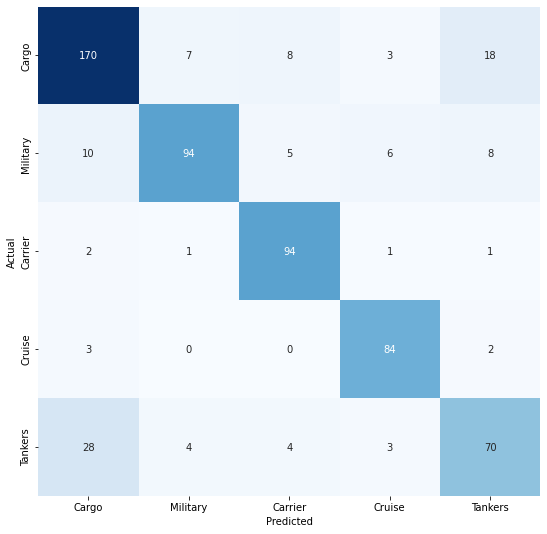

In [40]:
# Evaluation du modèle sur jeu de test :
test_model(model_vgg16_TL, X_test, Y_test)

## VII.2. XCeption, préentrainé sur le dataset Imagenet

In [32]:
from keras.applications.xception import Xception

In [28]:
# Traitement des données pour XCeption : (Prend un certain temps)
img_size_xc = 299

# Etape 1 - Conversion des images en niveau de gris 
path_i = path
path_o = './images_g_299'

# Etape 2 - Chargement des images dans un tableau
X_xc = load_data(df, path=path_o, target_size=(img_size_xc,img_size_xc))
print('Dimensions de X_xc : ', X_xc.shape)

# Paramètres pour la séparation des jeux de TRAIN et de TEST
test_s = 0.1 # Ratio des tailles des jeux Train/Test 
seed = 1234

# Séparation des jeux de TRAIN et de TEST
X_train_xc, X_test_xc, Y_train_xc, Y_test_xc = model_selection.train_test_split(X_xc, y, test_size=test_s, shuffle=True, random_state=seed)

print('Dimension X_train :', X_train_xc.shape)
print('Dimension Y_train :', Y_train_xc.shape)

print('Dimension X_test :', X_test_xc.shape)
print('Dimension Y_test :', Y_test_xc.shape)

Dimensions de X_xc :  (6252, 299, 299, 3)
Dimension X_train : (5626, 299, 299, 3)
Dimension Y_train : (5626, 5)
Dimension X_test : (626, 299, 299, 3)
Dimension Y_test : (626, 5)


In [34]:
def init_model_XCeption_TransferLearning():
    model = Xception(classes = 5,
                     weights = "imagenet", 
                     include_top=False, 
                     input_shape=(img_size_xc, img_size_xc, 3))
    
    # Ne pas réentrainer les couches cachées du réseau :
    for layer in model.layers:
        layer.trainable = False

    # Adaptation du réseau aux nouvelles classes :
    xception_flatten = Flatten()(model.output)
    prediction = Dense(num_classes, activation="softmax")(xception_flatten)
    xception_adapted = Model(inputs = model.input, outputs = prediction)

    xception_adapted.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return xception_adapted


In [36]:
# Paramètres d'apprentissage : 
n_epochs = 2
batch_size = 32

# Initialisation du réseau :
model_xception_TL = init_model_XCeption_TransferLearning()


# Visualisation de l'acrhitecture :
print('Architecture du modèle : ')
model_xception_TL.summary()
print("\nLancement de l'apprentissage :")

# Apprentissage sur le jeu (X_train, Y_train)
history_f = model_xception_TL.fit(X_train_xc, Y_train_xc, 
                    validation_split= 0.25,
                    batch_size=batch_size, 
                    epochs = n_epochs,
                   callbacks=[tensorboard_callback]) 

Architecture du modèle : 
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________

132/132 [==============================] - 369s 3s/step - loss: 2.3073 - accuracy: 0.7400 - val_loss: 2.3699 - val_accuracy: 0.7861
Epoch 2/2
132/132 [==============================] - 337s 3s/step - loss: 0.8651 - accuracy: 0.8711 - val_loss: 1.6141 - val_accuracy: 0.8216


Précision sur jeu de TEST : 81.46964856230032%


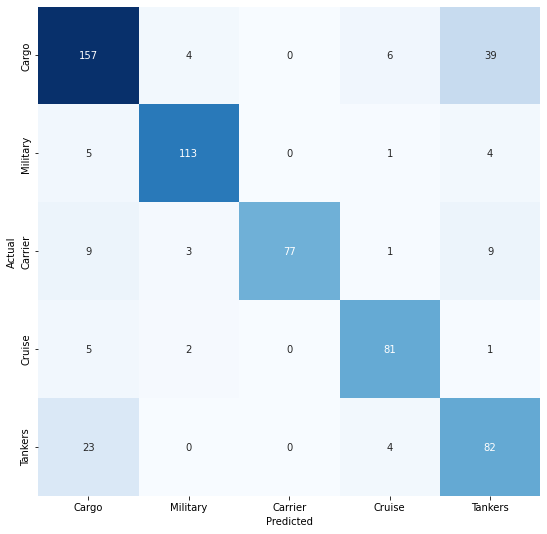

In [37]:
# Evaluation du modèle sur jeu de test :
test_model(model_xception_TL, X_test_xc, Y_test_xc)